In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pyproj
import math
from datetime import datetime
import statistics as stats

Abrimos el DF

In [185]:
df = pd.read_csv('..\Inventures-Test\Data\\vehicle_gps.csv')

Ploteamos para ver la forma de las calles

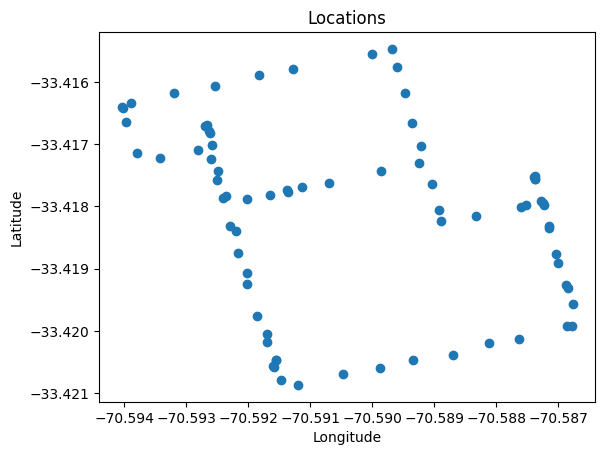

In [186]:
plt.scatter(df['longitude'], df['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations')
plt.show()

Creamos un convertidor de coordenadas lon, lat a x,y (Con un punto 0,0 comodo) y creamos otra funcion para devolverse en caso de ser necesario.

In [187]:

def Converter(lon, lat, ctype):
    """
    Converter toma coordenadas lon y lat y las convierte a un sistema cartesiano x, y en metros.
    Retorna x o y segun corresponda.
    Recibe:
        Longitud (float)
        Latitud (float)
        ctype (str) ('latitude' or 'longitude')
    Retorna:
        x (float) si ctype = 'longitude'
        y (float) si ctype = 'latitude'
    """
    # Definimos la proyección UTM para la zona correspondiente a la longitud de la ubicación
    utm_proj = pyproj.Proj(proj='utm', zone = 19, datum='WGS84')

    # Convertimos la lat y lon en coordenadas UTM x e y en metros
    x, y = utm_proj(lon, lat)

    # Movemos el punto 0,0 a un lugar comodo para el trabajo
    final = -351750 + x
    if ctype == 'latitude':
        final = 3699100 + y

    return final

import pyproj

def Unconverter(x, y, ctype):
    """
    Converter toma coordenadas x e y en metros, las convierte a un sistema coordenado lon, lat
    Retorna lon o lat segun corresponda.
    Recibe:
        x (float)
        y (float)
        ctype (str) ('x' or 'y')
    Retorna:
        lon (float) si ctype = 'x'
        lat (float) si ctype = 'y'
    """
    # Definir la proyección UTM inversa para la zona correspondiente a la ubicación
    utm_proj_inv = pyproj.Proj(proj='utm', zone= 19, datum='WGS84', units='m')

    # Recobramos el 0,0 original del UTM
    x = x + 351750 
    y = y - 3699100

    # Convertimos las coordenadas UTM x e y en latitud y longitud
    lon, lat = utm_proj_inv(x, y, inverse=True)
    final = lon
    if ctype == 'y':
        final = lat
    
    return final

Aplicamos la funcion al df segun corresponda

In [188]:
df['x'] = df.apply(
    lambda x: Converter(x['longitude'], x['latitude'], ctype='longitude'),  axis=1)
df['y'] = df.apply(
    lambda x: Converter(x['longitude'], x['latitude'], ctype='latitude'), axis=1)

Aplicamos el unconverter para testear su funcionamiento

In [189]:
df['x2'] = df.apply(
    lambda x: Unconverter(x['x'], x['y'], ctype='x'), axis=1)
df['y2'] = df.apply(
    lambda x: Unconverter(x['x'], x['y'], ctype='y'),  axis=1)

Ploteamos los puntos en el sistema x e y, vemos que se conserva la forma y tenemos unidades mas comodas de trabajar y siempre positivas

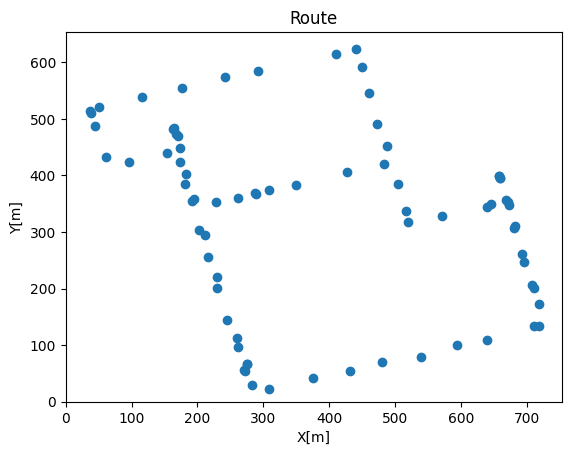

In [190]:
fig, ax = plt.subplots()
ax.scatter(df['x'],df['y'])
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.title('Route')
plt.show()

In [191]:
A = df.loc[df['vehicle']=='A']
B = df.loc[df['vehicle']=='B']
C = df.loc[df['vehicle']=='C']
D = df.loc[df['vehicle']=='D']

Ploteamos ahora separando segun el viaje realizado

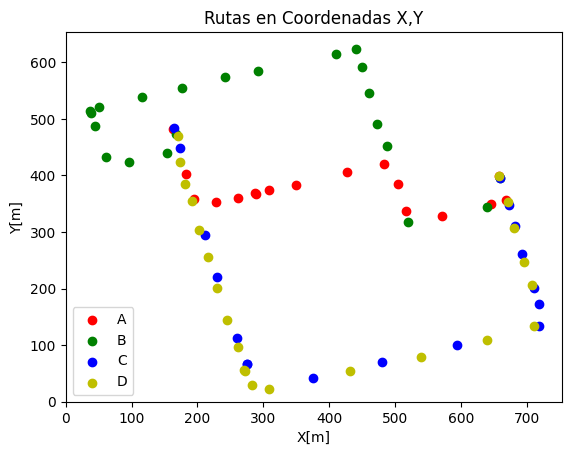

In [192]:
fig, ax = plt.subplots()
scatter_a = ax.scatter(A['x'], A['y'], color='r')
scatter_b = ax.scatter(B['x'], B['y'], color='g')
scatter_c = ax.scatter(C['x'], C['y'], color='b')
scatter_d = ax.scatter(D['x'], D['y'], color='y')

# Creamos la leyenda con las etiquetas y los colores correspondientes
ax.legend((scatter_a, scatter_b, scatter_c, scatter_d),
          ('A', 'B', 'C', 'D'),
          loc='lower left')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.title('Rutas en Coordenadas X,Y')
plt.show()

Observamos que el retorno a lat lon desde x e y es muy parecido al original

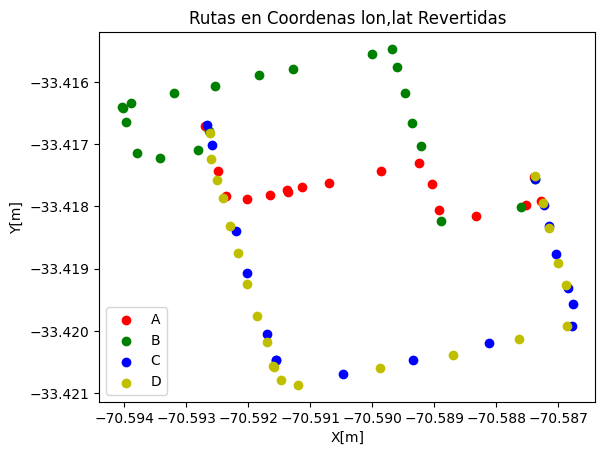

In [193]:
fig, ax = plt.subplots()
scatter_a = ax.scatter(A['x2'], A['y2'], color='r')
scatter_b = ax.scatter(B['x2'], B['y2'], color='g')
scatter_c = ax.scatter(C['x2'], C['y2'], color='b')
scatter_d = ax.scatter(D['x2'], D['y2'], color='y')

# Creamos la leyenda con las etiquetas y los colores correspondientes
ax.legend((scatter_a, scatter_b, scatter_c, scatter_d),
          ('A', 'B', 'C', 'D'),
          loc='lower left')

plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.title('Rutas en Coordenas lon,lat Revertidas')
plt.show()

In [194]:
df.drop(['x2', 'y2'], inplace=True, axis=1)

In [195]:
A = df.loc[df['vehicle']=='A']
B = df.loc[df['vehicle']=='B']
C = df.loc[df['vehicle']=='C']
D = df.loc[df['vehicle']=='D']

In [196]:
def As_list(df):
    """
    Convierte un dataframe a un diccionario con sus columnas como listas
    Recibe:
        dataframe (pandas df)
    Retorna:
        diccionario (dict)
    """
    columnas = df.columns
    resultado = {}
    for columna in columnas:
        nombre_lista = f"{columna}"
        resultado[nombre_lista] = df[columna].tolist()
    return resultado

In [197]:
A_dic = As_list(A)
B_dic = As_list(B)
C_dic = As_list(C)
D_dic = As_list(D)

In [198]:

def slope_change(x, y):
    """
    Recibe una lista de valores de y otra de valores de y, retorna los puntos iniciales, finales y donde existe un cambio de pendiente mayor a 45 grados 
    entre x[i-1], x[i] y x[i+1], si tienen una distancia minima de 5 metros, es decir detecta las esquinas.
    Recibe:
        x (Lista(float))
        y (Lista(float))
    Retorna:
        puntos_cambio_x (Lista(float))
        puntos_cambio_y (Lista(float))
    """

    puntos_cambio_x = []
    puntos_cambio_y = []
    
    # Puntos iniciales
    puntos_cambio_x.append(x[0])
    puntos_cambio_y.append(y[0])
    for i in range(1, len(x)-1):

        # Calculamos las pendientes con los puntos adyacentes.
        pendiente1 = math.atan2(y[i]-y[i-1], x[i]-x[i-1])
        pendiente2 = math.atan2(y[i+1]-y[i], x[i+1]-x[i])
        # Convertimos las pendientes a grados
        pendiente1_grados = math.degrees(pendiente1)
        pendiente2_grados = math.degrees(pendiente2)
        # Calculamos la diferencia de pendientes
        diferencia_pendiente = abs(pendiente2_grados - pendiente1_grados)

        # Calculamos la distancia entre puntos
        d_1 = math.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2)
        d_2 = math.sqrt((x[i+1]-x[i])**2 + (y[i+1]-y[i])**2)
        
        # Si la distancia con el anterior es muy pequeña, calcula la pendiente con el punto i-2
        if d_1<= 5:
            try:
                pendiente1 = math.atan2(y[i]-y[i-2], x[i]-x[i-2])
                pendiente2 = math.atan2(y[i+1]-y[i], x[i+1]-x[i])
                pendiente1_grados = math.degrees(pendiente1)
                pendiente2_grados = math.degrees(pendiente2)
                diferencia_pendiente = abs(pendiente2_grados - pendiente1_grados)
            except:
                pass
            diferencia_pendiente2 = abs(pendiente2_grados - pendiente1_grados)
            if diferencia_pendiente2 > 45:
                puntos_cambio_x.append(x[i])
                puntos_cambio_y.append(y[i])

        # Si la distancia con el siguiente es muy pequeña no hace nada
        # Asi si los puntos juntos estan en una esquina, solo determinamos uno como 
        # la esquina.
        elif d_2<=5: 
            pass
        
        # Si los puntos no estan juntos.
        elif diferencia_pendiente > 45:
            puntos_cambio_x.append(x[i])
            puntos_cambio_y.append(y[i])
    
    # Puntos finales
    puntos_cambio_x.append(x[-1])
    puntos_cambio_y.append(y[-1])

    return puntos_cambio_x, puntos_cambio_y

In [199]:
Ax, Ay= slope_change(A_dic['x'], A_dic['y'])
Bx, By= slope_change(B_dic['x'], B_dic['y'])
Cx, Cy= slope_change(C_dic['x'], C_dic['y'])
Dx, Dy= slope_change(D_dic['x'], D_dic['y'])

Ploteamos con las esquinas en distinto color para visualizar los datos

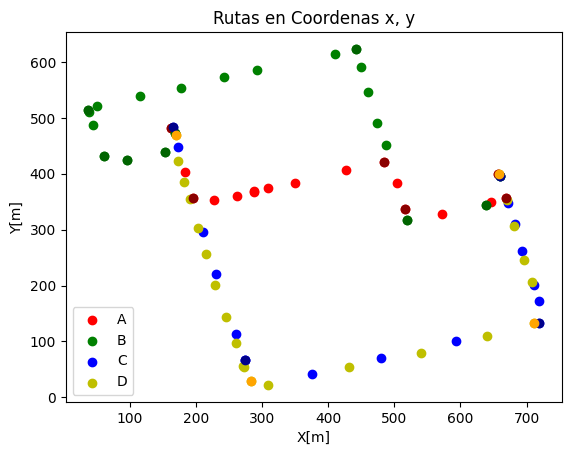

In [200]:
fig, ax = plt.subplots()
scatter_a = ax.scatter(A['x'], A['y'], color='r')
scatter_b = ax.scatter(B['x'], B['y'], color='g')
scatter_c = ax.scatter(C['x'], C['y'], color='b')
scatter_d = ax.scatter(D['x'], D['y'], color='y')
scatter_Ax = ax.scatter(Ax, Ay, color='#8B0000')
scatter_Bx = ax.scatter(Bx, By, color='#006400')
scatter_Cx = ax.scatter(Cx, Cy, color='#00008B')
scatter_Dx = ax.scatter(Dx, Dy, color='#FFA500')
# Creamos la leyenda con las etiquetas y los colores correspondientes
ax.legend((scatter_a, scatter_b, scatter_c, scatter_d),
          ('A', 'B', 'C', 'D'),
          loc='lower left')

plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.title('Rutas en Coordenas x, y')
plt.show()

Guardamos las esquinas y las modificamos ligeramente para centrarlas

In [201]:
Xs = [Ax[1], Dx[1]+5, Cx[2]+10, Ax[-2], Bx[-3], Ax[2]+10, Bx[-4], Bx[-5], 65, 173.20]
Ys = [Ay[1]-10, Dy[1]-15, Cy[2]+5, Ay[-2], By[-3], Ay[2]+2, By[-4], By[-5], 415, 448.40]

Redondeamos

In [202]:
Xs = [round(val, 2) for val in Xs]
Ys = [round(val, 2) for val in Ys]

Graficamos los resultados

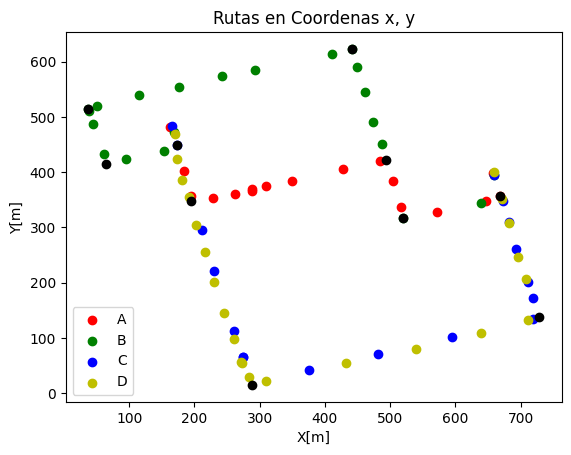

In [203]:
fig, ax = plt.subplots()
scatter_a = ax.scatter(A['x'], A['y'], color='r')
scatter_b = ax.scatter(B['x'], B['y'], color='g')
scatter_c = ax.scatter(C['x'], C['y'], color='b')
scatter_d = ax.scatter(D['x'], D['y'], color='y')
scatter_Ax = ax.scatter(Xs, Ys, color='black')
# Creamos la leyenda con las etiquetas y los colores correspondientes
ax.legend((scatter_a, scatter_b, scatter_c, scatter_d),
          ('A', 'B', 'C', 'D'),
          loc='lower left')

plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.title('Rutas en Coordenas x, y')
plt.show()

Creamos el grafo G con los el punto inicial, final y las esquinas como nodos

In [204]:
G = nx.Graph()
for i in range(10):
    interseccion = "Inter" + str(i+1)
    coordenadas = (Xs[i], Ys[i])
    G.add_node(interseccion, pos=coordenadas)

# Añadimos edges entre intersecciones contiguas
for i in range(9):
    G.add_edge("Inter"+str(i+1), "Inter"+str(i+2))
G.add_edge("Inter10", "Inter1")

# Añadimos puntos inciales y mas edges
Ter1 = (Cx[0], Cy[0])
Ter2 = (Cx[-1], Cy[-1])
G.add_node('Ter1', pos=Ter1)
G.add_node('Ter2', pos=Ter2)
G.add_edge("Ter1", "Inter10")
G.add_edge("Ter2", "Inter4")
G.add_edge('Inter1', 'Inter6')


El grafo ya tiene la forma deseada

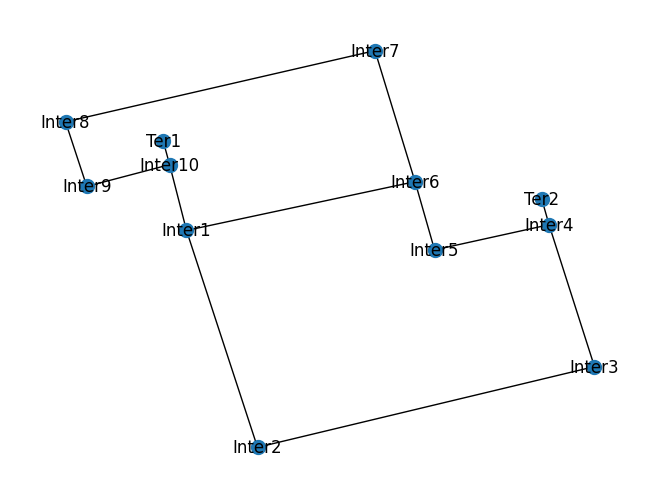

In [205]:
# Visualizamos el G
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos, node_size=100, with_labels=True)
plt.show()

In [206]:
def inter_nodes(Gi):
    """
    Recibe un grafo y lo modifica añadiendo nodos cada 10 metros en sus edges
    Recibe:
        Grafo (nx)
    Retorna:
    """

    # Lista de tuplas para almacenar los nodos originales
    originales = []

    # Iteramos sobre todas las conexiones existentes
    for u, v in list(Gi.edges()):
        coordenadas_u = np.array(Gi.nodes[u]['pos'])
        coordenadas_v = np.array(Gi.nodes[v]['pos'])
        distancia = np.linalg.norm(coordenadas_v - coordenadas_u)
        num_nodos = int(distancia / 10)
        if num_nodos > 0:
            # Añadimos los nodos intermedios y los edges correspondientes
            puntos = np.linspace(coordenadas_u, coordenadas_v, num_nodos + 2)[1:-1]
            anterior = u
            for i, punto in enumerate(puntos):
                nombre_nodo = "{}.{}.{}".format(u, v, i + 1)
                Gi.add_node(nombre_nodo, pos=punto)
                Gi.add_edge(anterior, nombre_nodo)
                anterior = nombre_nodo
            Gi.add_edge(anterior, v)

            # Agregamos nodos originales a la lista
            originales.append((u, v))

    # Eliminamos edges originales
    for u, v in originales:
        if Gi.has_edge(u, v):
            Gi.remove_edge(u, v)

In [207]:
inter_nodes(G)

Ahora el mapa esta mucho mejor representado por el grafo

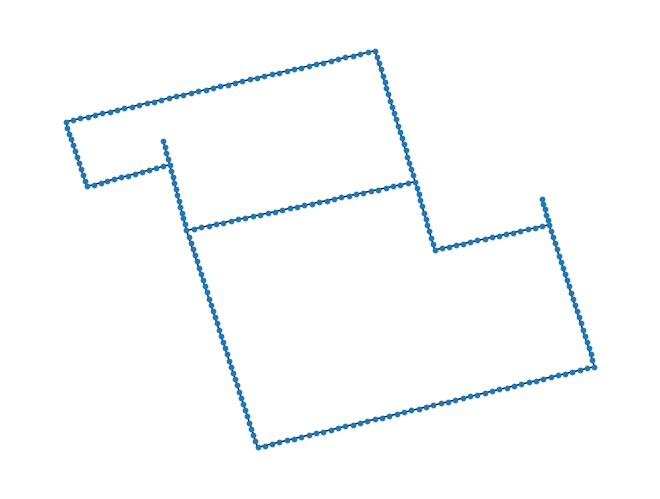

In [208]:
# Visualizamos el G
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos, node_size=10, with_labels=False)
plt.show()

In [209]:
df_clean = df # df.drop_duplicates(subset=['vehicle', 'timestamp'], keep='last')
A = df_clean.loc[df_clean['vehicle']=='A']
B = df_clean.loc[df_clean['vehicle']=='B']
C = df_clean.loc[df_clean['vehicle']=='C']
D = df_clean.loc[df_clean['vehicle']=='D']
A_dic = As_list(A)
B_dic = As_list(B)
C_dic = As_list(C)
D_dic = As_list(D)

In [210]:
def add_empty_list_to_edges(G):
    """
    Recibe un grafo, añade listas vacias a el parametro 'tiempo' y añade peso 10 al parametro 'weight' para todos sus edges.
    Recibe:
        Grafo (nx)
    Retorna:
    """
    
    for u, v, data in G.edges(data=True):
        data.setdefault('tiempo', [])
        data.setdefault('weight', 10)
add_empty_list_to_edges(G)

In [211]:
def nearest_node(x, y):
    """
    Recibe una coordenada y retorna el nodo mas cercano.
    Recibe:
        x (float)
        y (float)
    Retorna:
        Nodo (nx)
    """
    distances = [(node['pos'][0] - x)**2 + (node['pos'][1] - y)**2 for z, node in G.nodes(data=True)]
    closest_node = min(zip(distances, G.nodes()), key=lambda x: x[0])[1]
    return closest_node

In [212]:
def Ruta(x, y, time):
    """
    Recibe una lista de coordenadas y retorna los nodos mas cercano a todos sus puntos, 
    si algun nodo se repite seguidamente elimina la primera ocurrencia.
    Recibe:
        x Lista(float)
        y Lista(float)
        time Lista(datetime)
    Retorna:
        Nodos Lista(nx)
        Tiempos Lista(datetime)
    """
    Tiempo = []
    Nodes=[]
    for i in range(len(x)):
        node = nearest_node(x[i], y[i])
        if i <len(x)-1:
            next = nearest_node(x[i+1], y[i+1])
        if node != next:
            Nodes.append(node)
            Tiempo.append(time[i])

    return Nodes, Tiempo

In [213]:
def shortest_paths_between_nodes(nodes, tiempos):
    """
    Recibe una lista de nodos y tiempos, devuelve el viaje y tiempo que tomo el viaje
    en entre cada nodo contiguo de la lista entregada.
    Recibe:
        Nodos Lista(nx)
        Tiempos Lista(datetime)
    Retorna:
        Deltat Lista(Lista(float))
        Edges Lista(Lista(nx))
    """

    shortest_paths = []
    # Buscamos el camino de nodos mas corto en distancia entre los nodos consecutivos.
    for i in range(len(nodes) - 1):
        u, v = nodes[i], nodes[i+1]
        shortest_path = nx.dijkstra_path(G, u, v)
        shortest_paths.append(shortest_path)

    # Encontramos el deltaT entre los dos nodos
    diffs = []
    for i in range(len(tiempos)-1):
        u, v = tiempos[i], tiempos[i+1]
        date1 = datetime.strptime(u, '%d-%m-%Y %H:%M')
        date2 = datetime.strptime(v, '%d-%m-%Y %H:%M')
        diff = date2 - date1
        diffs.append(diff.total_seconds())

    # Encontramos los edges que hay entre medio de los dos nodos.
    shortest_path_edges = []
    for path in shortest_paths:
        path_edges = [[path[i], path[i+1]] for i in range(len(path)-1)]
        shortest_path_edges.append(path_edges)

    # Suponiendo que cada edge entre los nodos demoro lo mismo le asignamos el tiempo/ cantidad de edges
    diffs2 = []
    for i in range(len(diffs)):
        diff2 = diffs[i]/len(shortest_path_edges[i])
        diffs2.append(diff2)
    
    return diffs2, shortest_path_edges

In [214]:
def Tiempo_edges(diffs, edges):
    """
    Recibe una lista de listas con tiempos y uns lista de listas de edges, 
    le agrega el tiempo asignado al parametro 'tiempo' de los edges del grafo.
    Recibe:
        Deltat Lista(Lista(float))
        Edges Lista(Lista(nx))
    Retorna:
    """
    for i in range(len(diffs)):
        for j in range(len(edges[i])):
            nodo1 = edges[i][j][0]
            nodo2 = edges[i][j][1]
            diff = diffs[i]
            G[nodo1][nodo2]['tiempo'].append(diff)

In [215]:
NodesA, TiempoA = Ruta(A_dic['x'], A_dic['y'], A_dic['timestamp'])
NodesB, TiempoB = Ruta(B_dic['x'], B_dic['y'], B_dic['timestamp'])
NodesC, TiempoC = Ruta(C_dic['x'], C_dic['y'], C_dic['timestamp'])
NodesD, TiempoD = Ruta(D_dic['x'], D_dic['y'], D_dic['timestamp'])

In [216]:
diffA, edgesA = shortest_paths_between_nodes(NodesA, TiempoA)
diffB, edgesB = shortest_paths_between_nodes(NodesB, TiempoB)
diffC, edgesC = shortest_paths_between_nodes(NodesC, TiempoC)
diffD, edgesD = shortest_paths_between_nodes(NodesD, TiempoD)

In [217]:
Tiempo_edges(diffA, edgesA)
Tiempo_edges(diffB, edgesB)
Tiempo_edges(diffC, edgesC)
Tiempo_edges(diffD, edgesD)

In [218]:
def add_default_time(graph):
    """
    Si tiene algun edge cuyo parametro tiempo es una lista vacia, le añade un 0.
    Recibe:
        Grafo (nx)
    Retorna:
    """
    for u, v, data in graph.edges(data=True):
        if data["tiempo"] == []:
            data["tiempo"].append(0.0)

In [219]:
add_default_time(G)

In [220]:
def mean_time(graph):
    """
    Toma el parametro tiempo de los edges del grafo y reemplaza la lista de tiempos
    por su promedio.
    Recibe:
        Grafo (nx)
    Retorna:
    """
    for u, v, data in graph.edges(data=True):
        data['tiempo'] = stats.mean(data['tiempo'])

In [221]:
mean_time(G)

In [222]:
def camino_mas_corto_con_tiempo_total(G, nodo_origen, nodo_destino):
    """
    Recibe un grafo, un nodo inicial y uno final, retorna el camino mas corto en tiempo entre ambos nodos
    y entrega cuanto tarda.
    Recibe:
        Grafo (nx)
        Nodo (nx)
        Nodo (nx)
    Retorna:
        Camino (Lista)
        Tiempo (float)
    """
    # Ejecutamos el algoritmo de Dijkstra para encontrar el camino más corto
    camino_mas_corto = nx.dijkstra_path(G, nodo_origen, nodo_destino, weight='tiempo')
    
    # Calculamos el tiempo total del camino más corto
    tiempo_total = sum(G.get_edge_data(camino_mas_corto[i], camino_mas_corto[i+1])['tiempo']
                       for i in range(len(camino_mas_corto)-1))
    
    # Nos quedamos con los nombre de nodos de esquinas o terminales.
    camino_filtrado = [nodo[:8] for nodo in camino_mas_corto if len(nodo) <= 8]

    return camino_filtrado, tiempo_total

In [223]:
camino_mas_corto_con_tiempo_total(G, 'Ter1', 'Ter2')

(['Ter1', 'Inter10', 'Inter1', 'Inter6', 'Inter5', 'Inter4', 'Ter2'],
 971.8340336134463)